In [32]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA

from multiprocessing import Pool
from threadpoolctl import threadpool_limits

import warnings
warnings.filterwarnings("ignore")

import emcee
import corner

import inspect

# SPCA libraries
from SPCA import helpers, astro_models, make_plots, make_plots_custom, detec_models, bliss, freeze
from SPCA import Decorrelation_helper as dh


from exofile.archive import ExoFile

%matplotlib inline

In [3]:
from exofile.config import edit_param  # To edit

# from exofile.config import Param  # To show the current parameters
# from exofile.config import reset_param  # To reset parameters

from pathlib import Path

PATH_TO_EXOFILE_DIR = Path("/home/ldang05/SPCA_prj/SPCA")

# data = ExoFile.load()
# data.write(PATH_TO_EXOFILE_DIR / 'masterfile.ecsv')

In [4]:
# # # Edit the path to your local exofile
# edit_param(exofile=PATH_TO_EXOFILE_DIR / 'masterfile.ecsv')

# (ExoFile.load(query=False).by_pl_name('WASP-76 b'))['st_metfe'].data

# Enter in parameters that will define how the rest of the code will run

In [4]:
planet = 'WASP-76b'

channel = 'ch2'
# mode = 'Poly2_v1'
mode = 'PLDAper1_3x3_v1'
rootpath = '/home/ldang05/projects/def-ncowan/ldang05/Spitzer_Data/'

# parameters you do not wish to fit
dparams_input = []

# parameters you want to place a gaussian prior on
gparams = ['t0', 'per', 'a', 'inc']

# parameters you want to place a uniform prior on
uparams = ['rp', 'fp', 'q1', 'q2', 'inc', 'ecosw', 'esinw', 'sigF', 'gpLx', 'gpLy']
uparams_limits = [[0,1], [0,1], [0,1], [0,1], [70,90], [-1,1], [-1,1], [0,1], [-3,0],[-3,0]]
uparams.extend(['p'+str(i)+'_1' for i in range(1,26)]) # First order PLD terms
uparams.extend(['p'+str(i)+'_2' for i in range(1,26)]) # Second order PLD terms
uparams_limits.extend([[-3,3] for i in range(1,26)])
uparams_limits.extend([[-500,500] for i in range(1,26)])

binnedPhotometry = True                  # Whether or not to use the binned photometry
oldPhotometry = False                    # Whether photometry was computed before May 1, 2020 when flux conversion was patched
ncpu = 4                                 # The number of cpu threads to be used when running MCMC
runMCMC = True                           # whether to run MCMC or just load-in past results
nIterScipy = 10                          # Number of iterative scipy runs used to locate best-fit before starting MCMCs
nBurnInSteps2 = 7.5e3                    # number of steps to use for the second mcmc burn-in
nProductionSteps = 1.5e3                 # number of steps to use with mcmc production run
usebestfit = True                        # used best-fit instead of median of chain
secondOrderOffset = True                 # should you use the second order sinusoid terms when calculating offset
bestfitNbin = 50                         # the number of binned values to overplot on the bestfit 4-panel figure (use None if you don't want these overplotted)
nFrames  = 64                            # number of frames per binned data point
initializeWithOld = False                # initial with previous mcmc results using the same method
pldIgnoreFrames = True                   # Whether or not to use the PLD photometry that ignored bad frames
pldAddStack = False                      # Whether or not to use the PLD photometry that used background correction stacks
debug = False                            # True if user wants details about the lambda functions created

# Adding companion dilution correction factor for CoRoT-2b, WASP-12b, and WASP-103b
if planet=='CoRoT-2b':
    compFactor = 1+0.2046
elif planet=='WASP-12b':
    compFactor = 1+0.09976
elif planet=='WASP-12b_old':
    compFactor = 1+0.09085
elif planet=='WASP-103b':
    compFactor = 1+0.1234
else:
    compFactor = 1

# non-zero if you want to remove some initial data points
cut_tmp = 0

# Everything below can be run without interfering with it

In [5]:
if rootpath[-1]!='/':
    rootpath += '/'
if not binnedPhotometry:
    nFrames = 1

## Load data for fitting

In [6]:
# Figure out where data is located
if 'pldaper' in mode.lower():
    # Get separately aperture data for when running PLDAper, and decide if ignoreFrame from aperture photometry
    # foldername_aper, ignoreFrames = np.array(dh.findPhotometry(rootpath, planet, channel, 'Poly2_v1'))[[0,-1]]
    photometry_result = dh.findPhotometry(rootpath, planet, channel, 'Poly2_v1')
    foldername_aper, ignoreFrames = photometry_result[0], photometry_result[-1]

    if len(ignoreFrames)==0:
        pldIgnoreFrames = False
    else:
        pldIgnoreFrames = True
    foldername_psf = ''
else:
    foldername_aper = ''

if 'psfx' in mode.lower():
    foldername_psf = dh.findPhotometry(rootpath, planet, channel, 'PSFX')[0]
else:
    foldername_psf = ''

(foldername, filename, filename_full, savepath,
path_params, AOR_snip, aors, breaks, ignoreFrames) = dh.findPhotometry(rootpath, planet, channel,
                                                                       mode, pldIgnoreFrames, pldAddStack)

with open(rootpath+planet+'/analysis/'+channel+'/cutFirstAOR.txt', 'r') as file:
    cutFirstAOR = file.readline().strip()=='True'

# For datasets where the first AOR is peak-up data
if cutFirstAOR:
    rawfiles = np.sort(os.listdir(rootpath+planet+'/data/'+channel+'/'+aors[0]+'/'+channel+'/bcd/'))
    rawfiles  = [rawfile for rawfile in rawfiles if '_bcd.fits' in rawfile]
    cut = cut_tmp+len(rawfiles)
else:
    cut = cut_tmp

# loading full data set for BIC calculation afterwards
if 'pld' in mode.lower():
    # get data from unbinned photometry for chi2 on unbinned data calculation later
    Pnorm_full, flux_full, time_full = helpers.get_full_data(foldername, filename_full, mode,
                                                             foldername_aper=foldername_aper,
                                                             cut=cut, nFrames=nFrames, ignore=ignoreFrames)
    # Get Data we'll analyze
    if binnedPhotometry:
        Pnorm_0, flux0, time0 = helpers.get_data(foldername, filename, mode,
                                                 foldername_aper=foldername_aper)
        Pnorm, flux, time = helpers.get_data(foldername, filename, mode,
                                             foldername_aper=foldername_aper, cut=cut)
    else:
        Pnorm, flux, time = Pnorm_full, flux_full, time_full
        Pnorm0, flux0, time0 = helpers.get_full_data(foldername, filename_full, mode,
                                                     foldername_aper=foldername_aper,
                                                     nFrames=nFrames, ignore=ignoreFrames)
    
    pca = PCA(n_components=int(Pnorm_full.shape[0]-1))
    pca.fit(Pnorm_full.T)
    Pnorm_full = pca.transform(Pnorm_full.T).T
    Pnorm_full = np.append(np.ones_like(Pnorm_full[:1]), Pnorm_full, axis=0)
    
    pca = PCA(n_components=int(Pnorm.shape[0]-1))
    pca.fit(Pnorm.T)
    Pnorm = pca.transform(Pnorm.T).T
    Pnorm = np.append(np.ones_like(Pnorm[:1]), Pnorm, axis=0)
    
    if not oldPhotometry:
        if 'pldaper' in mode.lower():
            path_temp = foldername_aper
        else:
            path_temp = foldername
        if binnedPhotometry:
            path_temp += filename
        else:
            path_temp += filename_full
        sigF_photon_ppm = dh.get_photon_limit(path_temp, mode, nFrames, ignoreFrames)
    
    # FIX: Add an initial PLD plot
else:
    # get data from photometry
    (flux_full, time_full, xdata_full, ydata_full,
     psfxw_full, psfyw_full) = helpers.get_full_data(foldername, filename_full, mode,
                                                     foldername_psf=foldername_psf,
                                                     cut=cut, nFrames=nFrames, ignore=ignoreFrames)
    # Get Data we'll analyze
    if binnedPhotometry:
        flux0, time0, xdata0, ydata0, psfxw0, psfyw0 = helpers.get_data(foldername, filename, mode,
                                                                          foldername_psf=foldername_psf)
        flux, time, xdata, ydata, psfxw, psfyw = helpers.get_data(foldername, filename, mode,
                                                                    foldername_psf=foldername_psf, cut=cut)
        
        if not oldPhotometry:
            sigF_photon_ppm = dh.get_photon_limit(foldername+filename, mode, nFrames, ignoreFrames)
    else:
        flux, time, xdata, ydata, psfxw, psfyw = (flux_full, time_full, xdata_full, ydata_full,
                                                  psfxw_full, psfyw_full)
        flux0, time0, xdata0, ydata0, psfxw0, psfyw0 = helpers.get_full_data(foldername, filename_full, mode,
                                                                             foldername_psf=foldername_psf,
                                                                             cut=cut, nFrames=nFrames,
                                                                             ignore=ignoreFrames)
        
        if not oldPhotometry:
            sigF_photon_ppm = dh.get_photon_limit(foldername+filename_full, mode, nFrames, ignoreFrames)
    
    ## FIX: peritime doesn't get made
    if True:#'ecosw' in dparams_input and 'esinw' in dparams_input:
        # make photometry plots
        make_plots.plot_photometry(time0, flux0, xdata0, ydata0, psfxw0, psfyw0, 
                                   time, flux, xdata, ydata, psfxw, psfyw, breaks, savepath,
                                   showPlot=True)
    else:
        # plot raw data
        make_plots.plot_photometry(time0, flux0, xdata0, ydata0, psfxw0, psfyw0, 
                                   time, flux, xdata, ydata, psfxw, psfyw, breaks, savepath,
                                   peritime, showPlot=True)

# Calculate the photon noise limit
if oldPhotometry:
    # Fix the old, unhelpful units to electrons to compute photon noise limit
    if binnedPhotometry:
        sigF_photon_ppm = dh.get_photon_limit_oldData(rootpath, foldername+filename_full, foldername_aper+filename_full,
                                                      planet, channel, mode, aors, nFrames, ignoreFrames)
    else:
        sigF_photon_ppm = dh.get_photon_limit_oldData(rootpath, foldername+filename, foldername_aper+filename,
                                                      planet, channel, mode, aors, nFrames, ignoreFrames)
        
sigF_photon_ppm *= compFactor

## Load archival/custom data and prepare some variables

In [7]:
import pickle

# ======================================================================================================================
# Run until here when connected to the internet
# ======================================================================================================================

## Download the most recent exoplanet archive data, and select the best constrained value for each parameter
dh.downloadExoplanetArchive()
if planet!='WASP-18b':
    p0_obj = dh.loadArchivalData(rootpath, planet, channel)

    PATH_TO_SAVE = Path("/home/ldang05/projects/def-ncowan/ldang05/Spitzer_Data") / planet
    # PATH_TO_SAVE.mkdir(parents=True, exist_ok=True) # Make sure the directory exists or create it if needed
    pickle_file = PATH_TO_SAVE / 'p0_obj.pkl'

    if not pickle_file.exists():
        with open(pickle_file, 'wb') as pf:
            pickle.dump(p0_obj, pf)
            print('pickle file saved to', pickle_file)
    
## If you would rather load your own data (e.g. your planet isn't in the exoplanet archive),
## you can use the function below. The error parameters are optional inputs, but are required if you want
## to put a prior on a parameter.
if planet=='WASP-18b':
    # The combination of parameters loaded for WASP-18b are not consistent with each other
    p0_obj = dh.loadCustomData(rootpath, planet, channel, 0.09716, 3.562, 0.9414526, 2458375.169883,
                               84.88, 0.0091, 269, 6431, 4.47, 0.11,
                               0.00014, 0.022, 0.000026, 0.0000016, 0.33, 0.00200, 3, 48)
    
# p0_obj = loadCustomData(rootpath, planet, channel, rp, a, per, t0, inc, e, argp, Tstar, logg, feh,
#                         rp_err, a_err, t0_err, per_err, inc_err, e_err, argp_err, Tstar_err)

# if you want to use the best fit params from a previous MCMC run            
if initializeWithOld:
    p0_obj = dh.reload_old_fit(path_params, p0_obj, mode)
if 'bliss' in mode.lower() and not runMCMC and not initializeWithOld:
    # Reload the number of bliss knots used so that you don't need to rerun initilization to remake outputs
    Table_par = np.load(path_params)
    p0_obj['nBinX'] = Table_par['nBinX'][0]
    p0_obj['nBinY'] = Table_par['nBinY'][0]
    
# makes list of parameters that won't be fitted 
dparams = helpers.expand_dparams(dparams_input, mode)

In [9]:
# rootpath = '/home/ldang05/projects/def-ncowan/ldang05/Spitzer_Data/'
# planet = 'WASP-76b'
# PATH_TO_SAVE = Path(rootpath) / planet
# print(PATH_TO_SAVE)
# pickle_file = PATH_TO_SAVE / 'p0_obj.pkl'

# if pickle_file.exists():
#         try:
#             with open(pickle_file, 'rb') as fp:
#                 p0_obj = pickle.load(fp)
#                 print(p0_obj)
#         except Exception as e:
#             print(f'Error loading pickle file: {e}')
# else:
#     raise FileNotFoundError(f'{pickle_file} does not exist.')

In [10]:
# # When offline:
# def get_planet_data(planet): # case-sensitive
#     planet_data = ExoFile.load(query=False).by_pl_name(planet)
    
#     # Define the variable names and their corresponding data names
#     variable_mapping = {
#         'rp': 'pl_ratror',
#         'a': 'pl_ratdor',
#         'per': 'pl_orbper',
#         't0': 'pl_tranmid',
#         'inc': 'pl_orbincl',
#         'e': 'pl_orbeccen',
#         'argp': 'pl_orblper',
#         'Tstar': 'st_teff',
#         'logg': 'st_logg',
#         'feh': 'st_metfe',
#         'rp_err': 'pl_ratrorerr1',
#         'a_err': 'pl_ratdorerr1',
#         'per_err': 'pl_orbpererr1',
#         't0_err': 'pl_tranmiderr1',
#         'inc_err': 'pl_orbinclerr1',
#         'e_err': 'pl_orbeccenerr1',
#         'argp_err': 'pl_orblpererr1',
#         'Tstar_err': 'st_tefferr1',
#     }

#     # Create a dictionary to store the variables
#     variables = {}

#     # Take the absolute value of each variable and store it in the dictionary
#     for var_name, var_data_name in variable_mapping.items():
#         variables[var_name] = abs(planet_data[var_data_name].data)

#     # Now you can access the absolute values using variable names
#     rp = variables['rp']
#     a = variables['a']
#     print(a)
#     per = variables['per']
#     t0 = variables['t0']
#     inc = variables['inc']
#     e = variables['e']
#     argp = variables['argp']
#     Tstar = variables['Tstar']
#     logg = float(variables['logg'])
#     feh = float(variables['feh'])
#     rp_err = variables['rp_err']
#     a_err = variables['a_err']
#     per_err = variables['per_err']
#     t0_err = variables['t0_err']
#     inc_err = variables['inc_err']
#     e_err = variables['e_err']
#     argp_err = variables['argp_err']
#     Tstar_err = variables['Tstar_err']

#     parameters = [rp[0], a[0], per[0], t0[0], inc[0], e[0], argp[0], Tstar[0], logg, feh, rp_err[0], a_err[0], t0_err[0], per_err[0], inc_err[0], e_err[0], argp_err[0], Tstar_err[0]]

#     return parameters


# parameters = get_planet_data(planet_archive)
# p0_obj = dh.loadCustomData(rootpath, planet, channel, *parameters)
# print(p0_obj)

## Initialize the guessed parameters

In [11]:
p0, p0_labels, p0_fancyLabels = helpers.get_p0(dparams, p0_obj)

## Setup detector, astrophysical, and full-signal functions and prepare priors

In [12]:
# Get the astrophysical function
astro_func, astro_labels = freeze.make_lambdafunc(astro_models.ideal_lightcurve, p0_labels,
                                                  dparams, p0_obj, debug=debug)
astro_inputs = time
astro_inputs_full = time_full

# Compute an initial guess for the astro model
astro_guess = astro_func(astro_inputs, **dict([[label, p0[i]] for i, label in enumerate(p0_labels)
                                               if label in astro_labels]))

# Get the function that checks whether the lightcurve is positive
positivity_func, positivity_labels = freeze.make_lambdafunc(astro_models.check_phase, p0_labels,
                                                            np.append(dparams, 'checkPhasePhis'),
                                                            p0_obj, debug=debug)

# Get all of the detector functions used and freeze any requested parameters
detec_funcs = []
# Get the names of the fitted parameters for each function
detec_labels = []
# Get the inputs needed for each detector function
detec_inputs = []
detec_inputs_full = []
if 'poly' in mode.lower():
    func = detec_models.detec_model_poly
    func, labels = freeze.make_lambdafunc(func, p0_labels, dparams, p0_obj, debug=debug)
    detec_funcs.append(func)
    detec_labels.append(labels)
    detec_inputs.append([xdata, ydata, mode])
    detec_inputs_full.append([xdata_full, ydata_full, mode])
if 'pld' in mode.lower():
    func = detec_models.detec_model_PLD
    func, labels = freeze.make_lambdafunc(func, p0_labels, dparams, p0_obj, debug=debug)
    detec_funcs.append(func)
    detec_labels.append(labels)
    detec_inputs.append([Pnorm, mode])
    detec_inputs_full.append([Pnorm_full, mode])
if 'bliss' in mode.lower():
    func = detec_models.detec_model_bliss
    func, labels = freeze.make_lambdafunc(func, p0_labels, dparams, p0_obj, debug=debug)
    detec_funcs.append(func)
    detec_labels.append(labels)
    detec_inputs.append(bliss.precompute(flux, xdata, ydata, p0_obj['nBinX'], p0_obj['nBinY']))
    detec_inputs_full.append(bliss.precompute(flux_full, xdata_full, ydata_full,
                                              p0_obj['nBinX'], p0_obj['nBinY']))
if 'gp' in mode.lower():
    func = detec_models.detec_model_GP
    func, labels = freeze.make_lambdafunc(func, p0_labels, dparams, p0_obj, debug=debug)
    detec_funcs.append(func)
    detec_labels.append(labels)
    detec_inputs.append([flux, xdata, ydata, True])
    detec_inputs_full.append([flux_full, xdata_full, ydata_full, True])
if 'hside' in mode.lower():
    for i, brk in enumerate(breaks):
        # Set the break points for the heaviside function
        p0_obj[f's{i}break'] = brk
        dparams = np.append(dparams, [f's{i}break'])
        p0_fancyLabels = p0_fancyLabels[p0_labels!=f's{i}break']
        p0_labels = p0_labels[p0_labels!=f's{i}break']
    for i in range(len(breaks), 5):
        p0_fancyLabels = p0_fancyLabels[p0_labels!=f's{i}']
        p0_labels = p0_labels[p0_labels!=f's{i}']
        p0_fancyLabels = p0_fancyLabels[p0_labels!=f's{i}break']
        p0_labels = p0_labels[p0_labels!=f's{i}break']
        dparams = np.append(dparams, [f's{i}'])
        dparams = np.append(dparams, [f's{i}break'])
    func = detec_models.hside
    func, labels = freeze.make_lambdafunc(func, p0_labels, dparams, p0_obj, debug=debug)
    detec_funcs.append(func)
    detec_labels.append(labels)
    detec_inputs.append(time)
    detec_inputs_full.append(time_full)
if 'tslope' in mode.lower():
    func = detec_models.tslope
    func, labels = freeze.make_lambdafunc(func, p0_labels, dparams, p0_obj, debug=debug)
    detec_funcs.append(func)
    detec_labels.append(labels)
    detec_inputs.append(time)
    detec_inputs_full.append(time_full)
if 'psfw' in mode.lower():
    func = detec_models.detec_model_PSFW
    func, labels = freeze.make_lambdafunc(func, p0_labels, dparams, p0_obj, debug=debug)
    detec_funcs.append(func)
    detec_labels.append(labels)
    detec_inputs.append([psfxw, psfyw])
    detec_inputs_full.append([psfxw_full, psfyw_full])
    
if len(detec_funcs)==0:
    raise NotImplementedError(f'mode=\'{mode}\' is not implemented.')

# Put gparams and uparams in the right order and remove any that aren't being fitted
gparams = np.array([parm for parm in p0_labels if parm in gparams])
uparams_unsorted = np.copy(uparams)
uparams = np.array([parm for parm in p0_labels if parm in uparams])
uparams_limits = np.array([uparams_limits[np.where(uparams_unsorted==uparams[i])[0][0]]
                           for i in range(len(uparams))])

gpriorInds = np.array([np.where(p0_labels==gpar)[0][0] for gpar in gparams])
upriorInds = np.array([np.where(p0_labels==upar)[0][0] for upar in uparams if upar in p0_labels])
if 'gp' in mode.lower():
    gammaInd = np.where(p0_labels=='gpAmp')[0][0]
else:
    gammaInd = None

# set up Gaussian priors
priors, errs = dh.setup_gpriors(gparams, p0_obj)
    
# Get the full-signal function that models the astrophysical and detector signals
signal_func = detec_models.signal
signal_inputs = [p0_labels, astro_func, astro_labels, astro_inputs, detec_funcs, detec_labels, detec_inputs]
signal_inputs_full = [p0_labels, astro_func, astro_labels, astro_inputs_full,
                      detec_funcs, detec_labels, detec_inputs_full]

lnprob_inputs = [flux, mode, p0_labels, signal_func, signal_inputs,
                 gpriorInds, priors, errs, upriorInds, uparams_limits, gammaInd,
                 positivity_func, positivity_labels]

## Run initial optimization on detector parameters

### Run several gradient descents, short MCMCs, and then gradient descents to allow full burn-in

#### Feel free to use your own maximum likelihood method - here we just offer a simple method that should often work. The objective of this step is just to start the final MCMC in a reasonable region of parameter space

Optimizing detector parameters first...
Running iterative scipy.optimize on all parameters


100%|██████████| 10/10 [00:55<00:00,  5.56s/it]

Improved ln-likelihood!
ln-likelihood: 6956.12
Running first mini burn-ins



100%|██████████| 386/386 [00:20<00:00, 18.95it/s]

Mean burn-in acceptance fraction: 0.306



100%|██████████| 386/386 [00:20<00:00, 19.03it/s]

Mean burn-in acceptance fraction: 0.307



100%|██████████| 386/386 [00:20<00:00, 18.76it/s]

Mean burn-in acceptance fraction: 0.310



100%|██████████| 386/386 [00:20<00:00, 19.24it/s]

Mean burn-in acceptance fraction: 0.311



100%|██████████| 386/386 [00:21<00:00, 17.59it/s]

Mean burn-in acceptance fraction: 0.313



100%|██████████| 386/386 [00:22<00:00, 17.03it/s]

Mean burn-in acceptance fraction: 0.354



100%|██████████| 386/386 [00:24<00:00, 15.65it/s]

Mean burn-in acceptance fraction: 0.372



100%|██████████| 386/386 [00:19<00:00, 19.74it/s]

Mean burn-in acceptance fraction: 0.308



100%|██████████| 386/386 [00:21<00:00, 17.96it/s]

Mean burn-in acceptance fraction: 0.317



100%|██████████| 386/386 [00:23<00:00, 16.34it/s]

Mean burn-in acceptance fraction: 0.334
Running final iterative scipy.optimize on all parameters



100%|██████████| 10/10 [00:58<00:00,  5.82s/it]

Improved ln-likelihood!
ln-likelihood: 7531.44


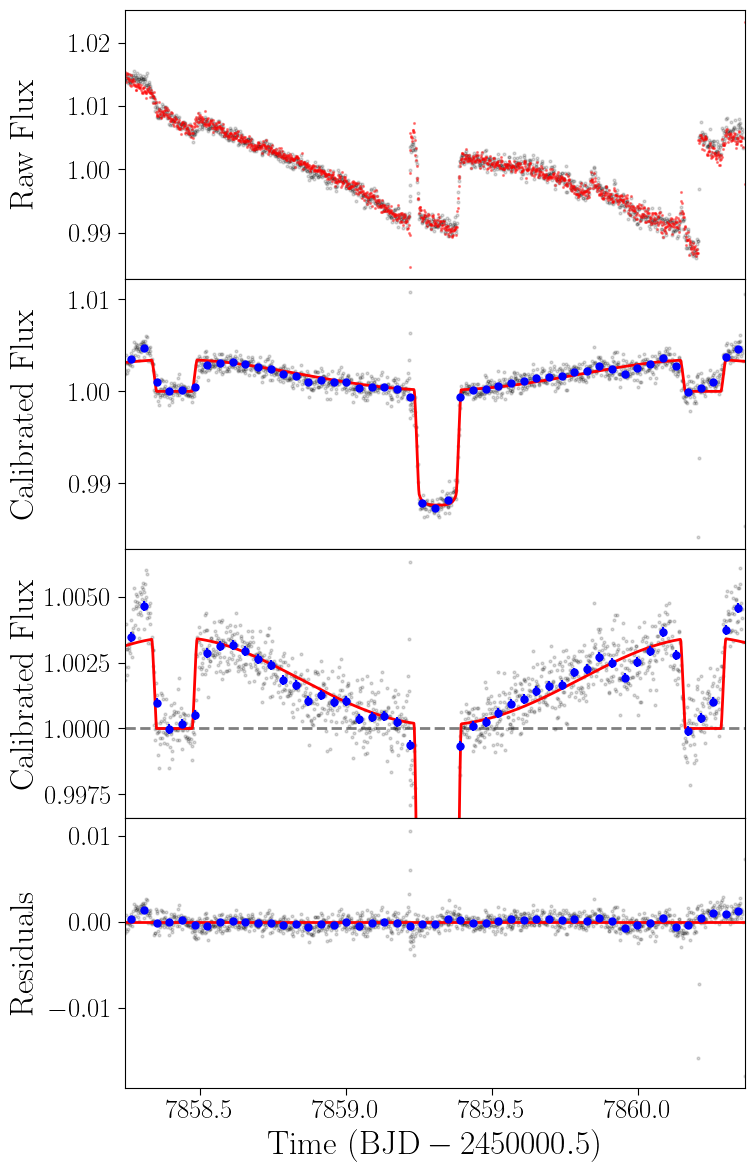

In [13]:
if runMCMC and not initializeWithOld:
    
    p0 = dh.burnIn(p0, p0_labels, mode, astro_func, astro_labels, astro_inputs, astro_inputs_full, 
                   signal_func, signal_inputs, signal_inputs_full, lnprob_inputs,
                   gparams, gpriorInds, priors, errs, time, flux, breaks,
                   bestfitNbin, ncpu, savepath, showPlot=True, nIterScipy=nIterScipy)

## Run the MCMC

Running MCMC


100%|██████████| 60/60 [00:06<00:00,  9.37it/s]


Mean acceptance fraction: 0.343


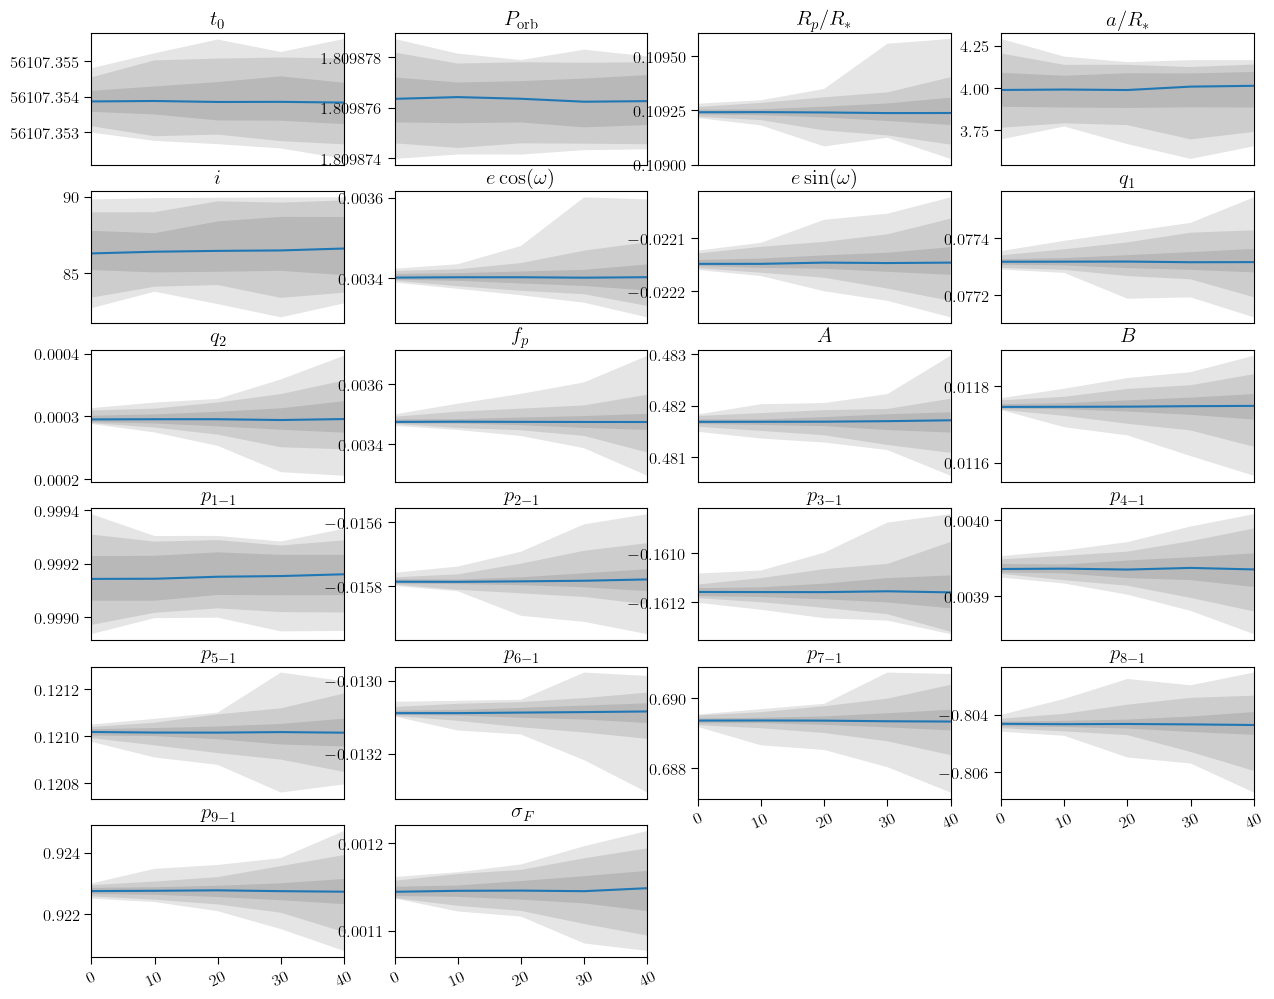

In [14]:
ndim, nwalkers = len(p0), 150

if runMCMC:
    # get scattered starting points in parameter space
    # MUST have the initial spread such that every walker passes the lnprior functions
    p0_rel_errs = 1e-4*np.ones_like(p0)
    gpriorInds = [np.where(p0_labels==gpar)[0][0] for gpar in gparams]
    p0_rel_errs[gpriorInds] = np.array(errs)/np.array(priors)
    pos0 = np.array([p0*(1+p0_rel_errs*np.random.randn(ndim))+p0_rel_errs/10.*np.abs(np.random.randn(ndim))
                     for i in range(nwalkers)])

    # Make sure that all starting positions pass the lnpriors, fix them if they don't
    priorlnls = np.array([np.isinf(helpers.lnprob(p_tmp, *lnprob_inputs)) for p_tmp in pos0])
    iters = 10
    while np.any(priorlnls) and iters>0:
        p0_rel_errs /= 1.5
        pos0[priorlnls] = np.array([p0*(1+p0_rel_errs*np.random.randn(ndim))
                                      +p0_rel_errs/10.*np.abs(np.random.randn(ndim))
                                    for i in range(np.sum(priorlnls))])
        priorlnls[priorlnls] = np.array([np.isinf(helpers.lnprob(p_tmp, *lnprob_inputs))
                                         for p_tmp in pos0[priorlnls]])
        iters -= 1
    if iters==0 and np.any(priorlnls):
        print('Warning: Some of the initial values still fail the lnprior!')
        print('The following MCMC will likely not work')

    # Run the MCMC
    print('Running MCMC')
    with threadpool_limits(limits=1, user_api='blas'):
        with Pool(ncpu) as pool:
            sampler = emcee.EnsembleSampler(nwalkers, ndim, helpers.lnprob, pool=pool, args=lnprob_inputs)
            pos2, prob, state = sampler.run_mcmc(pos0, int(np.rint((nBurnInSteps2+nProductionSteps))/nwalkers),
                                                 progress=True)
    print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
    
    # Show the evolution of MCMC walkers
    burnInChain = sampler.chain[:,:int(np.rint((nBurnInSteps2)/nwalkers)),:]
    fname = savepath+'MCMC_burninWalkers_'+mode+'.pdf'
    make_plots.walk_style(burnInChain, p0_fancyLabels, 10, fname, showPlot=True)
    
    # Get only the production steps
    lnprobchain = sampler.get_log_prob(discard=int(np.rint((nBurnInSteps2)/nwalkers))).swapaxes(0,1)
    chain = sampler.get_chain(discard=int(np.rint((nBurnInSteps2)/nwalkers))).swapaxes(0,1)

    #Saving MCMC Results
    pathchain = savepath + 'samplerchain_'+mode+'.npy'
    pathlnlchain = savepath + 'samplerlnlchain_'+mode+'.npy'
    pathposit = savepath + 'samplerposi_'+mode+'.npy'
    pathlnpro = savepath + 'samplerlnpr_'+mode+'.npy'
    np.save(pathchain, chain)
    np.save(pathlnlchain, lnprobchain)
    np.save(pathposit, pos2)
    np.save(pathlnpro, prob)   
    
else:

    pathchain = savepath + 'samplerchain_'+mode+'.npy'
    pathlnlchain = savepath + 'samplerlnlchain_'+mode+'.npy'
    chain = np.load(pathchain)
    lnprobchain = np.load(pathlnlchain)
    
    pathlnpro = savepath + 'samplerlnpr_'+mode+'.npy'
    if os.path.exists(pathlnpro):
        lnprobability = np.load(pathlnpro)

samples = chain.reshape((-1, ndim))

## Output results from MCMC

In [15]:
p0_mcmc, MCMC_Results, residuals = dh.print_MCMC_results(flux, flux_full, chain, lnprobchain, mode, channel,
                                                         signal_func, signal_inputs, signal_inputs_full,
                                                         p0_labels, p0_obj, astro_func, astro_inputs,
                                                         astro_inputs_full, astro_labels, usebestfit, savepath,
                                                         sigF_photon_ppm, nFrames, secondOrderOffset,
                                                         compFactor)

MCMC result:

      t0 = 56107.354037714336  +0.0006406250977306627  -0.0006693999239359982
     per = 1.8098758655911655  +9.106609966114121e-07  -9.50096747720508e-07
      rp = 0.10918019581187403  +9.455150257364764e-05  -8.878570273751496e-05
       a = 4.015211512333463  +0.08151562442519289  -0.15204386415900606
     inc = 86.46693063536792  +2.0252610130984294  -2.0644253286411924
   ecosw = 0.0034237643428131404  +4.2863455798143775e-05  -4.9551357879159576e-05
   esinw = -0.022169361980242004  +4.658215203854482e-05  -4.375182740153083e-05
      q1 = 0.07735799152353848  +6.136984993447558e-05  -6.547684064849013e-05
      q2 = 0.0003232437429935539  +3.8824881769939745e-05  -3.1377643246067435e-05
      fp = 0.003456754379765939  +4.2818538826805246e-05  -3.6077735307513906e-05
       A = 0.481578570030176  +0.00031974085665531504  -0.0003571341148964069
       B = 0.011764427405575815  +5.2135367905263574e-05  -6.162277126109221e-05
    p1_1 = 0.9991602435852217  +7.2089963

Binned data:
    chi2 = 1391.0144811823081
    chi2datum = 0.9816615957532168
    Likelihood = 7591.112541418701
    Evidence = 7511.293271782103
    BIC = -15022.586543564206

Unbinned data:
    chi2 = 114653.87074250057
    chi2datum = 1.263556692739622
    Likelihood = 284628.53276301414
    Evidence = 284502.9595951549
    BIC = -569005.9191903098


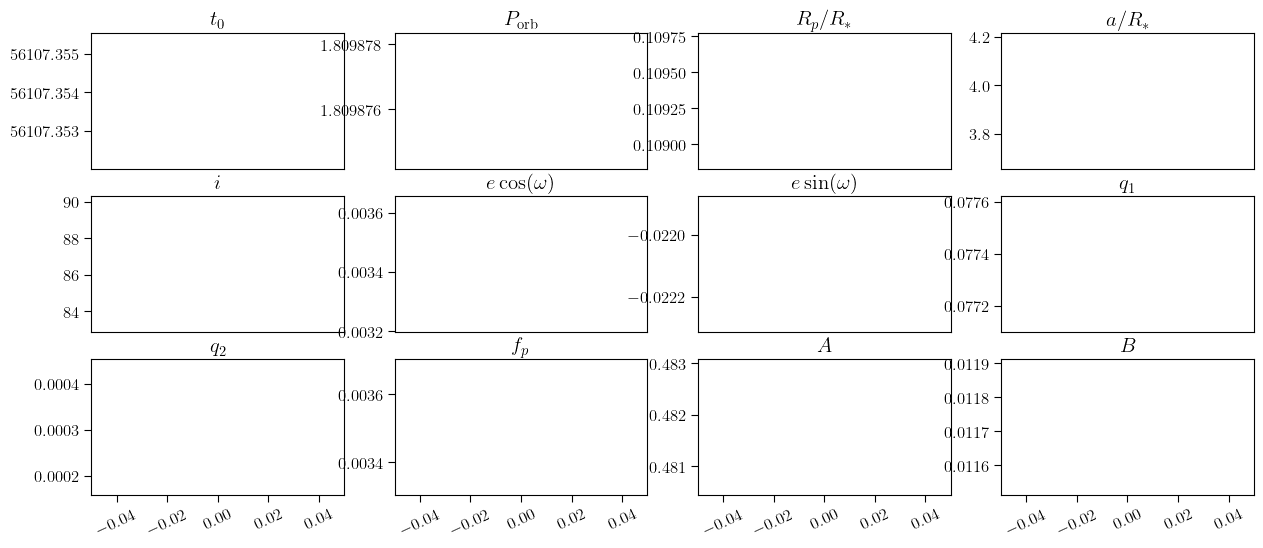

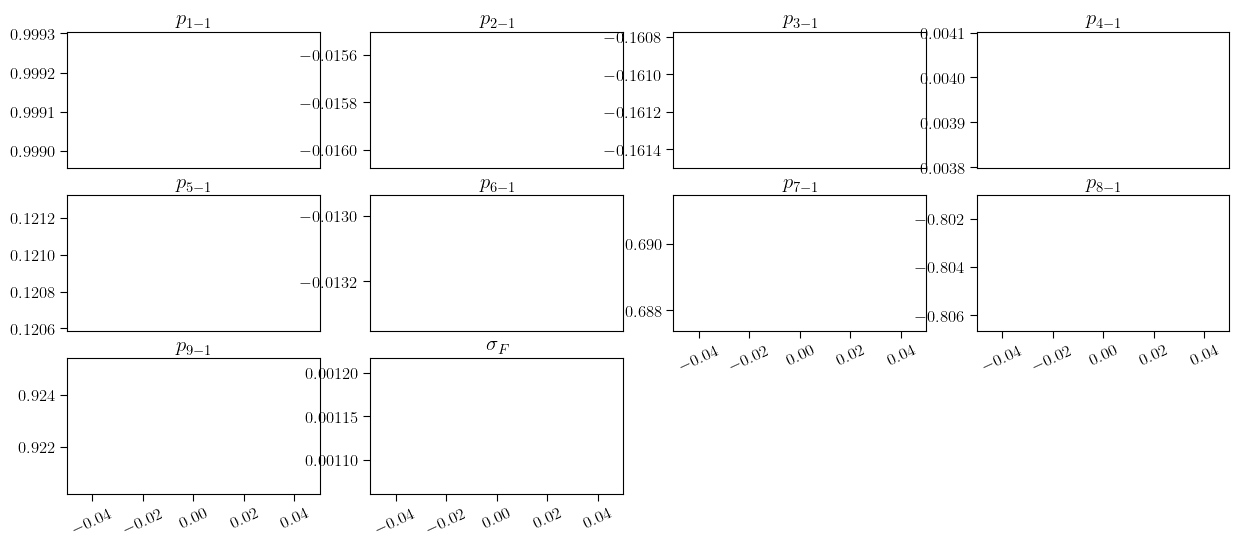

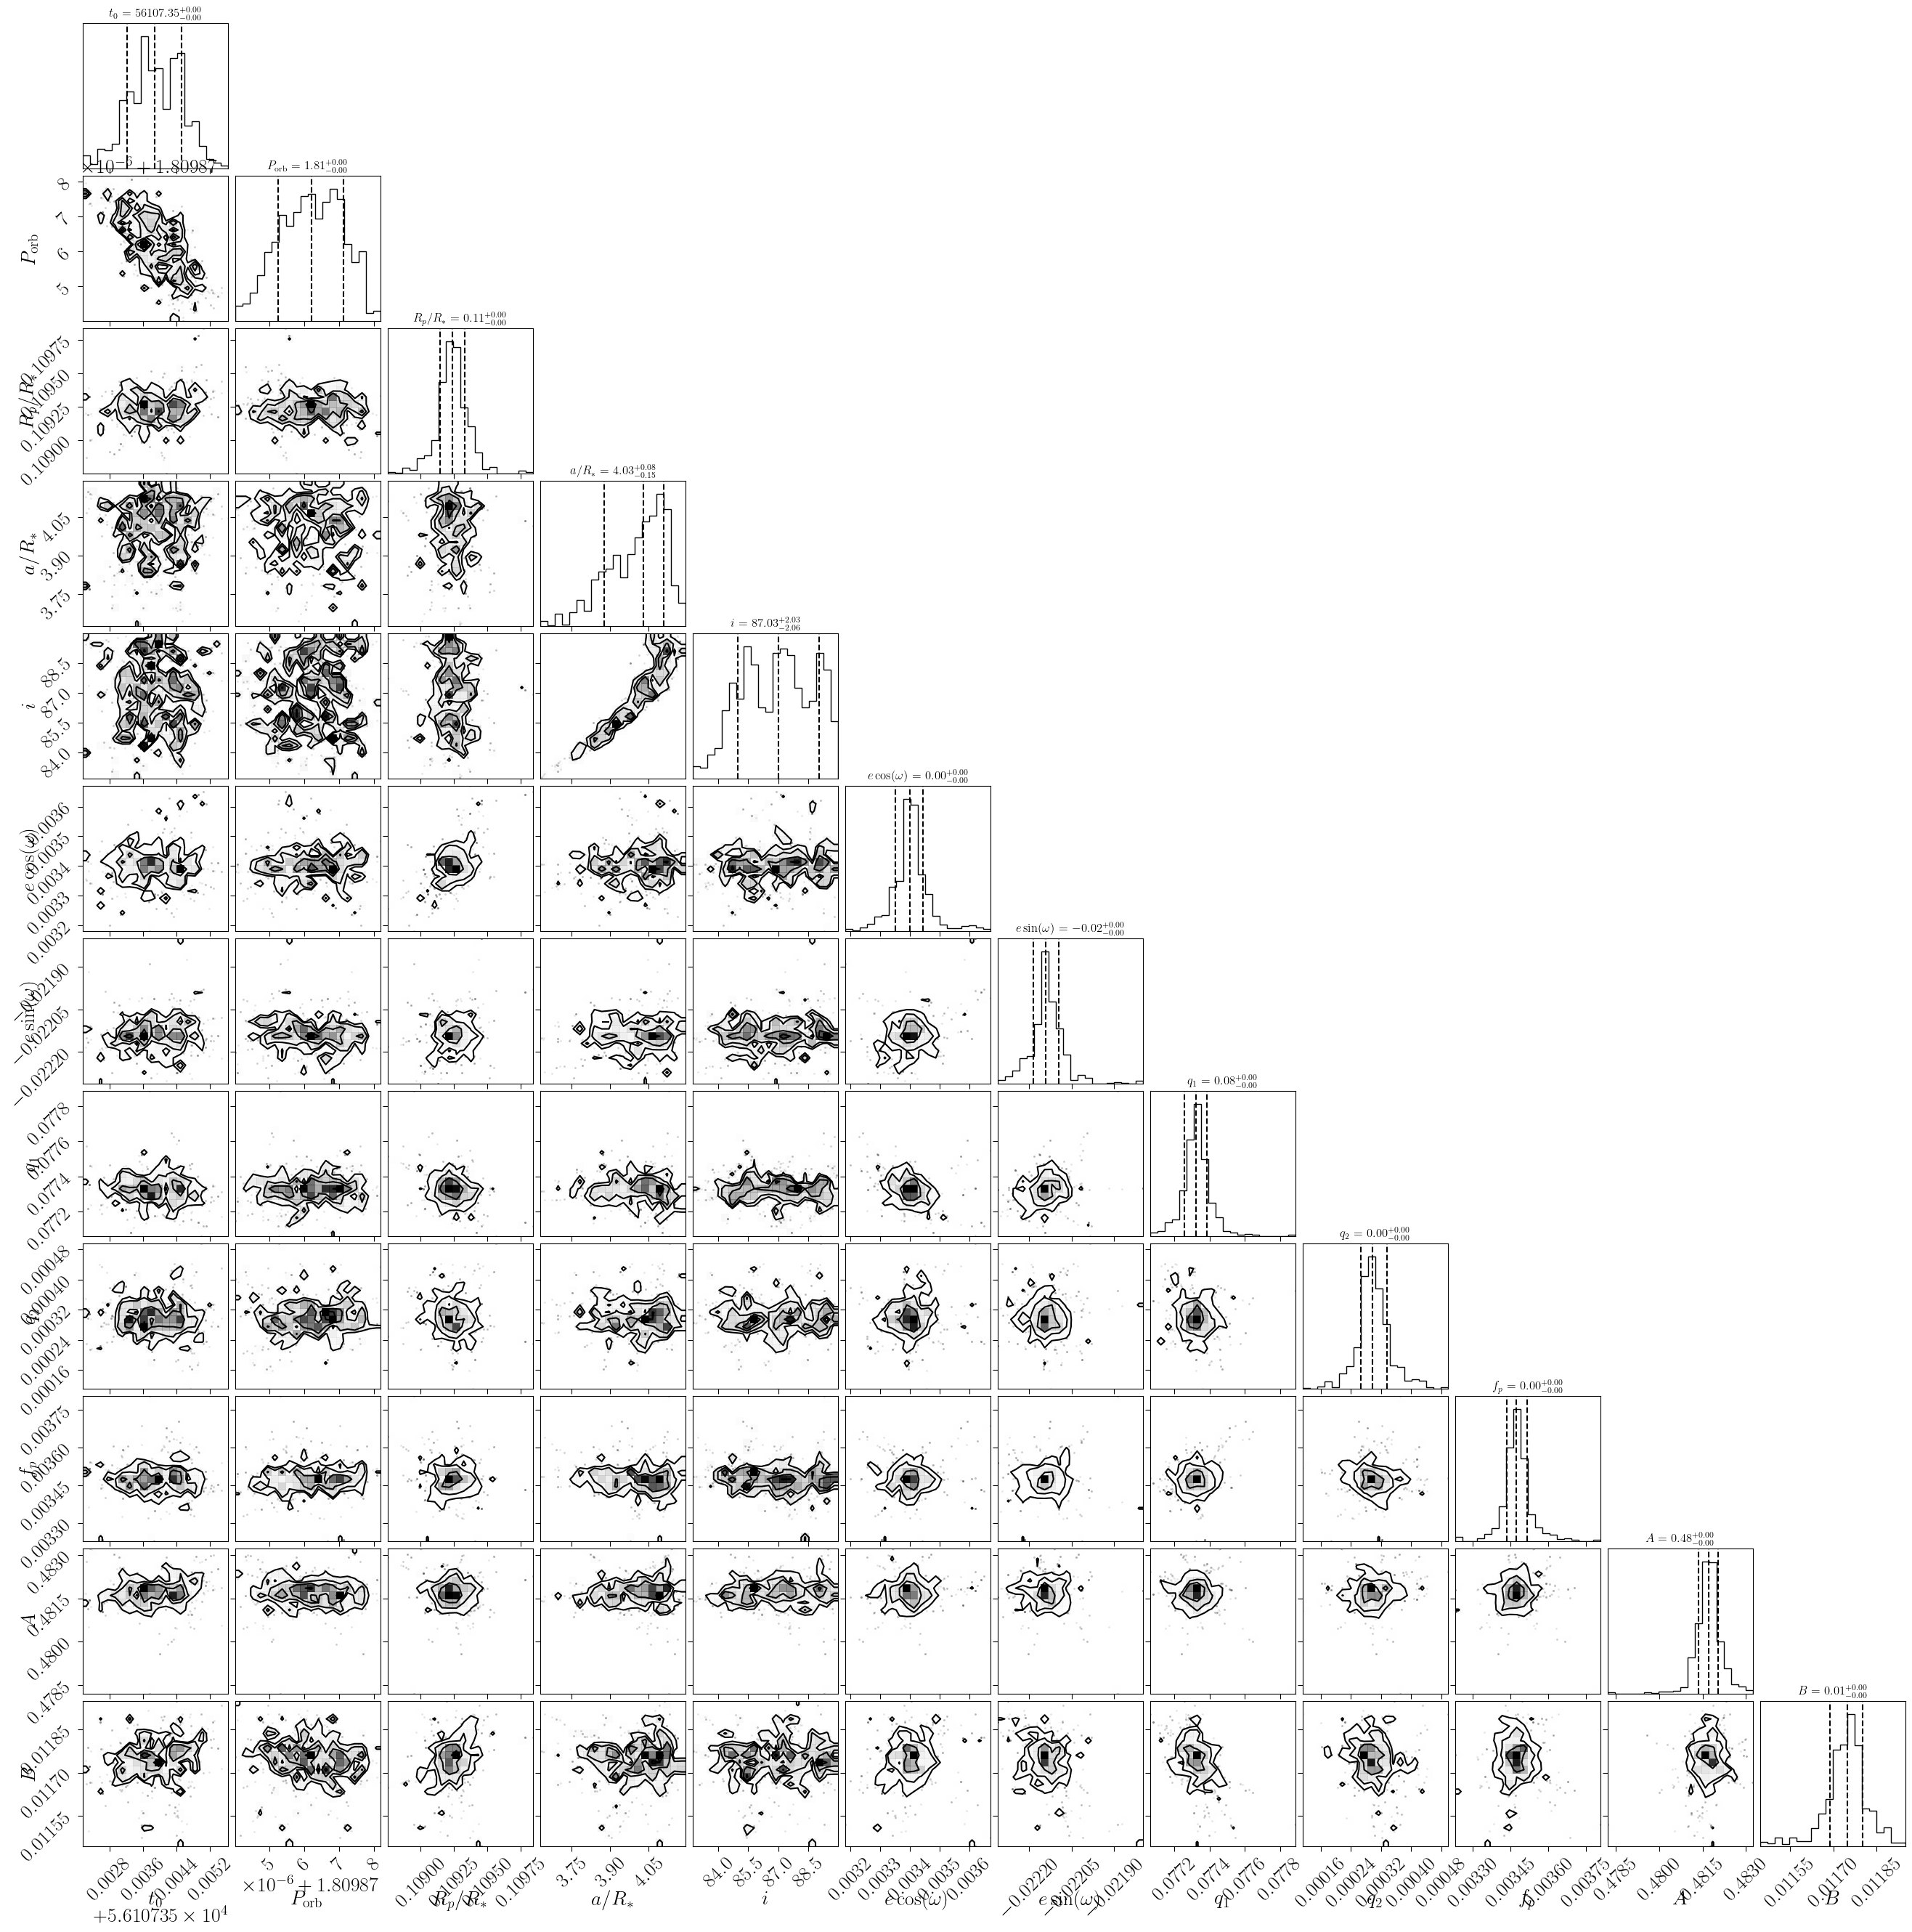

In [16]:
# Make a plot showing the evolution of the astro parameters
ind_a = len(astro_labels) # index where the astro params
labels = p0_fancyLabels[np.in1d(p0_labels, astro_labels)]
fname = savepath+'MCMC_astroWalkers_'+mode+'.pdf'
make_plots.walk_style(chain[:,:,:ind_a], labels, 10, fname, showPlot=True)

# Make a plot showing the evolution of the detector parameters
if 'bliss' not in mode.lower() or r'$\sigma_F$' in p0_fancyLabels:
    labels = p0_fancyLabels[np.logical_not(np.in1d(p0_labels, astro_labels))]
    fname = savepath+'MCMC_detecWalkers_'+mode+'.pdf'
    make_plots.walk_style(chain[:,:,ind_a:], labels, 10, fname, showPlot=True)

# Make a corner plot for the astro parameters
if runMCMC:
    labels = p0_fancyLabels[np.in1d(p0_labels, astro_labels)]
    fig = corner.corner(samples[:,:ind_a], labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, 
                        plot_datapoints=True, title_kwargs={"fontsize": 12})
    plotname = savepath + 'MCMC_corner_'+mode+'.pdf'
    fig.savefig(plotname, bbox_inches='tight')
    plt.show()
    plt.close()

In [17]:
# Clear out the RAM
samples = None
sampler = None
chain = None
lnprobchain = None

## Plot the final model (best-fit parameters if usebestfit==True, otherwise median of MCMC chain)

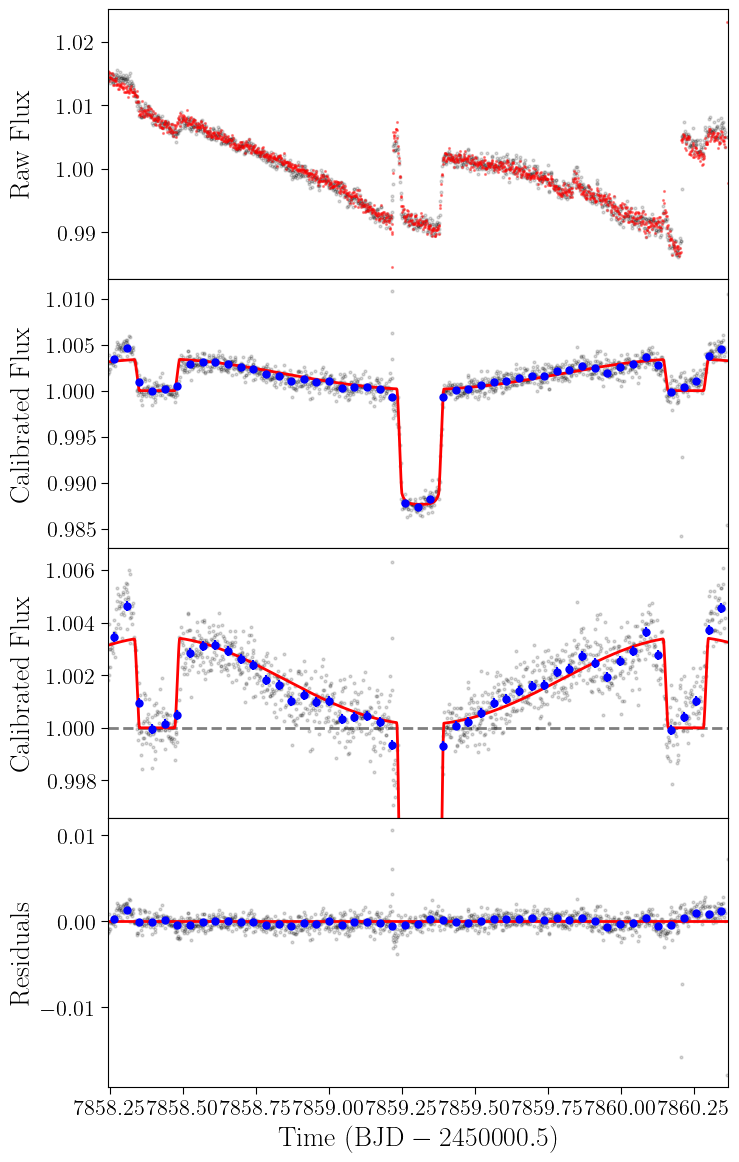

In [18]:
astroModel = astro_func(astro_inputs, **dict([[label, p0_mcmc[i]] for i, label in enumerate(p0_labels)
                                              if label in astro_labels]))
signalModel = signal_func(p0_mcmc, *signal_inputs)
detecModel = signalModel/astroModel

make_plots.plot_model(time, flux, astroModel, detecModel, breaks, savepath, 'Bestfit_'+mode+'.pdf',
                      nbin=bestfitNbin, showPlot=True)

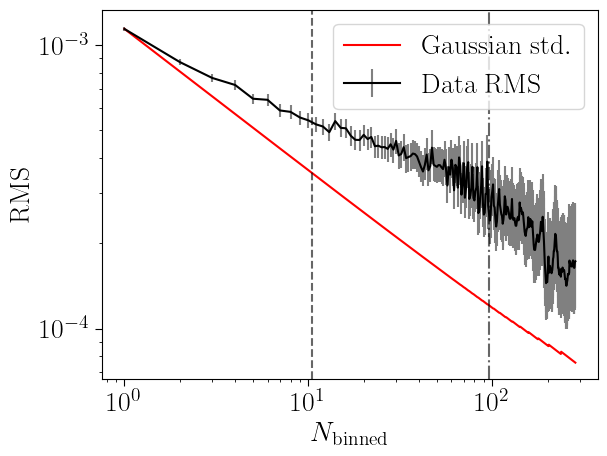

Over Ingress (22.6 min):
Expected Noise (ppm)	Observed Noise (ppm)
361.9736664923662	542.6887988617951
Observed/Expected
1.4992493904891286

Over Transit/Eclipse (206.6 min):
Expected Noise (ppm)	Observed Noise (ppm)
121.44006119671569	270.9137060106015
Observed/Expected
2.2308429635238713


In [19]:
#WARNING: these durations assume circular orbits!!!
intTime = (time[1]-time[0])
ingrDuration = helpers.getIngressDuration(p0_mcmc, p0_labels, p0_obj, intTime)
occDuration = helpers.getOccultationDuration(p0_mcmc, p0_labels, p0_obj, intTime)

minBins = 5

make_plots.plot_rednoise(residuals, minBins, ingrDuration, occDuration, intTime,
                         mode, savepath, savetxt=True, showPlot=True)

## Look for residual correlations after fit

In [20]:
if 'pld' not in mode.lower():
    make_plots.look_for_residual_correlations(time, flux, xdata, ydata, psfxw, psfyw, residuals,
                                              p0_mcmc, p0_labels, p0_obj, mode, savepath, showPlot=True)

# Zoe's testing

In [1]:
# Check what is in the pickle file and make a table

import pandas as pd
import pickle

# Load data from the pickle file
file_path = '/home/ldang05/projects/def-ncowan/ldang05/Spitzer_Data/KELT-20b/analysis/ch2/addedBlank/noIgnore/4umExactCircular2_2_movingCentroid/BLISS_v1_PSFW_TruePSFW/Bestfit_BLISS_v1_PSFW_TruePSFW.pkl'  # Replace with your pickle file path
with open(file_path, 'rb') as file:
    loaded_data = pickle.load(file)

# Extract data from loaded_data
time = loaded_data[1]
flux = loaded_data[2]
astro = loaded_data[3]
detec = loaded_data[4]
breaks = loaded_data[5]

# Check if all arrays have the same length
if len(set(len(arr) for arr in [time, flux, astro, detec, breaks])) == 1:
    # All arrays have the same length, so you can create a DataFrame
    data = {
        'time': time,
        'flux': flux,
        'astro': astro,
        'detec': detec,
        # 'breaks': breaks
    }

    df = pd.DataFrame(data)

    # Display the DataFrame
    print(df)

In [115]:
mainpath   = '/home/ldang05/projects/def-ncowan/ldang05/Spitzer_Data/'
planets  = ['KELT-20b']
channels = ['ch2']

path = mainpath + planets[0] +'/analysis/'+channels[0]+'/addedBlank/noIgnore/'
print(path)

# mega_keys = ['Poly2', 'Poly3', 'Poly4', 'Poly5', 'BLISS', 
#              'PLDAper1', 'PLDAper2', '3x3', '5x5', 'v1', 'v2', 'TruePSFW', 'PSFW_TruePSFW']

cols = ['Poly2', 'Poly3', 'Poly4', 'Poly5', 'BLISS', 'PLDAper1_3x3', 'PLDAper1_5x5']
rows = ['v1_TruePSFW', 'v1_PSFW_TruePSFW', 'v2_TruePSFW', 'v2_PSFW_TruePSFW']


mintime = 8536.0+2450000.5 # 56417.2414096537
maxtime = 8539.8+2450000.5 # 56420.8356839537

minflux = 0.98
maxflux = 1.005

/home/ldang05/projects/def-ncowan/ldang05/Spitzer_Data/KELT-20b/analysis/ch2/addedBlank/noIgnore/


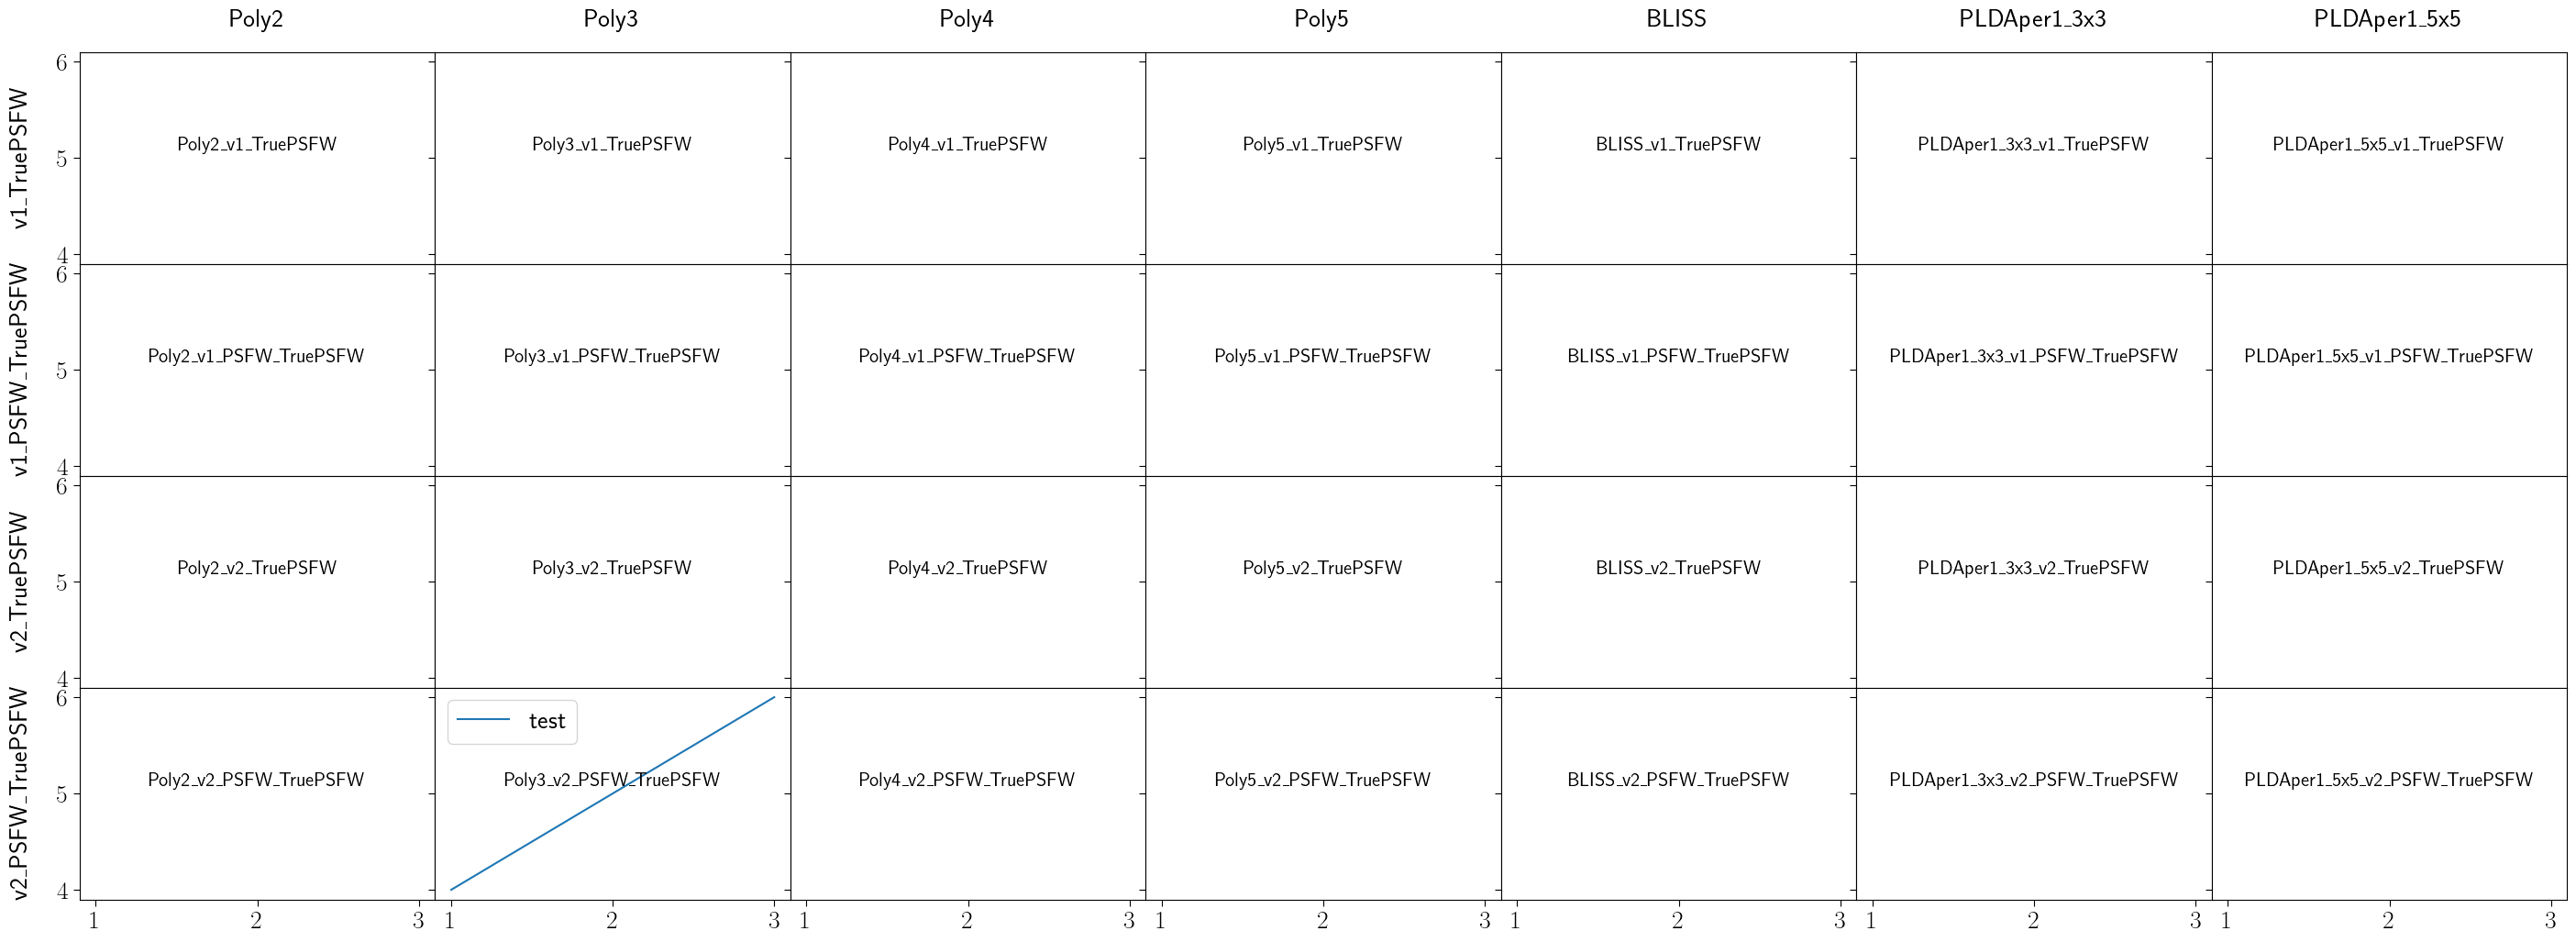

In [116]:
import matplotlib.pyplot as plt

def create_subplot_names(rows, cols):
    # Create a dictionary to store subplot axes and their names
    subplot_names = {}

    # Create subplots with increased spacing
    fig, axes = plt.subplots(nrows=len(rows), ncols=len(cols), sharex=True, sharey=True, figsize=(35, len(rows)*3))

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0, hspace=0)  # Adjust the values as needed

    # Iterate through rows and columns to name the subplots
    for i, row in enumerate(rows):
        for j, col in enumerate(cols):
            subplot_name = f"{col}_{row}"  # Switched order to col_row
            ax = axes[i, j]
            subplot_names[subplot_name] = ax

            # Set the title in the middle of each subplot
            ax.set_title(subplot_name, fontsize=15, x=0.5, y=0.5, loc="center")  # Adjust the fontsize as needed

            # Set row names as labels for y axes for the first column
            if j == 0:
                ax.set_ylabel(row, fontsize=20, labelpad=20)  # Row name as y-axis label

    # Set column names at the top of the subplot (not as titles)
    for j, col in enumerate(cols):
        ax = axes[0, j]  # Access the top row of subplots
        ax.xaxis.set_label_position('top')  # Move the x-axis label to the top
        ax.set_xlabel(col, fontsize=20, labelpad=20)  # Column name as x-axis label

    return fig, subplot_names

# Example usage
# rows = ['v1_TruePSFW', 'v1_PSFW_TruePSFW', 'v2_TruePSFW', 'v2_PSFW_TruePSFW']
# cols = ['Poly2', 'Poly3', 'Poly4', 'Poly5', 'BLISS', 'PLDAper1_3x3', 'PLDAper1_5x5']
fig, subplot_dict = create_subplot_names(rows, cols)

# Now you can access the axes using their names
ax = subplot_dict[cols[1] + '_' + rows[3]] # 'Poly2_v1_TruePSFW'
ax.plot([1, 2, 3], [4, 5, 6], label='test')
ax.legend()
plt.show()


In [126]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from SPCA import helpers

def plot_model(time, flux, astro, detec, breaks, 
               axName=None,
               savepath=None, plotName='Combined_plot.pdf', plotTrueAnomaly=False, nbin=None, showPlot=False, fontsize=20):
    
    mcmc_signal = astro * detec
    
    if plotTrueAnomaly:
        # FIX: convert time to true anomaly for significantly eccentric planets!!
        # Use p0_mcmc if there, otherwise p0_obj
        x = time
    else:
        x = time - 5e4
    
    if nbin is not None:
        x_binned, _ = helpers.binValues(x, x, nbin)
        calibrated_binned, calibrated_binned_err = helpers.binValues(flux / detec, x, nbin, assumeWhiteNoise=True)
        residuals_binned, residuals_binned_err = helpers.binValues(flux / detec - astro, x, nbin, assumeWhiteNoise=True)
    
    # fig, axes = plt.subplots()
    axes = subplot_dict[axName]
    print('~~~~~~~~~~~~~~~~~ plotted to axes ~~~~~~~~~~~~~~~~~')

    # axes.plot(x, flux / detec, '.', color='k', markersize=4, alpha=0.15)
    axes.plot(x, astro, color='r', linewidth=2)
    if nbin is not None:
        axes.errorbar(x_binned, calibrated_binned, yerr=calibrated_binned_err, fmt='.',
                      color='blue', markersize=4, alpha=0.2)
        # print('max is ', np.nanmax(calibrated_binned))
        # print('min is ', np.nanmin(calibrated_binned))
        
    # axes.set_ylabel(r'$\rm Calibrated~Flux$', fontsize=fontsize)

    if showPlot:
        plt.show()
    
    # plt.close()
    return # x, astro, x_binned, calibrated_binned

# plot_model(time, flux, astro, detec, breaks, showPlot=True, nbin=300)

In [123]:
import os
import glob

mode_list = []
for mode_c in cols:
    for mode_r in rows:
        mode_cat = mode_c + '_' + mode_r
        mode_list.append(mode_cat)
print('mode_list is ', mode_list)

found_modes = set()
# ---------------------------------------------------------

# List all files and directories in the specified path
contents = os.listdir(path)
print(contents)

# Iterate through the contents and print their names
for dir_4um in contents:
    dir_path = os.path.join(path, dir_4um)
    mode_folders = os.listdir(dir_path)
    
    for mode_folder in mode_folders:
        if mode_folder in mode_list:
            found_modes.add(mode_folder)
            print('mode_folder is ', mode_folder)
            mode_path = os.path.join(dir_path, mode_folder)
            bestfit_file = glob.glob(os.path.join(mode_path, 'Bestfit_*.pkl'))[0]
            print(bestfit_file)

            print('----------------------------------------------------------------')
            with open(bestfit_file, 'rb') as file:
                bestfit_data = pickle.load(file)
            
            # Extract data from loaded_data
            time = loaded_data[1]
            flux = loaded_data[2]
            astro = loaded_data[3]
            detec = loaded_data[4]
            breaks = loaded_data[5]

            plot_model(time, flux, astro, detec, breaks, axName=mode_folder, showPlot=True, nbin=300)
            print('--------------------------- PLOTTED -------------------------------')

        else:
            print('False')
            print('----------------------------------------------------------------')

not_found_modes = set(mode_list) - found_modes

print('Modes not found in mode_folder:')
for mode in not_found_modes:
    print(mode)


mode_list is  ['Poly2_v1_TruePSFW', 'Poly2_v1_PSFW_TruePSFW', 'Poly2_v2_TruePSFW', 'Poly2_v2_PSFW_TruePSFW', 'Poly3_v1_TruePSFW', 'Poly3_v1_PSFW_TruePSFW', 'Poly3_v2_TruePSFW', 'Poly3_v2_PSFW_TruePSFW', 'Poly4_v1_TruePSFW', 'Poly4_v1_PSFW_TruePSFW', 'Poly4_v2_TruePSFW', 'Poly4_v2_PSFW_TruePSFW', 'Poly5_v1_TruePSFW', 'Poly5_v1_PSFW_TruePSFW', 'Poly5_v2_TruePSFW', 'Poly5_v2_PSFW_TruePSFW', 'BLISS_v1_TruePSFW', 'BLISS_v1_PSFW_TruePSFW', 'BLISS_v2_TruePSFW', 'BLISS_v2_PSFW_TruePSFW', 'PLDAper1_3x3_v1_TruePSFW', 'PLDAper1_3x3_v1_PSFW_TruePSFW', 'PLDAper1_3x3_v2_TruePSFW', 'PLDAper1_3x3_v2_PSFW_TruePSFW', 'PLDAper1_5x5_v1_TruePSFW', 'PLDAper1_5x5_v1_PSFW_TruePSFW', 'PLDAper1_5x5_v2_TruePSFW', 'PLDAper1_5x5_v2_PSFW_TruePSFW']
['4umPSF', '4umExactCircular2_2_movingCentroid', '4umPLD_3x3', '4umPLD_5x5']
False
----------------------------------------------------------------
False
----------------------------------------------------------------
False
----------------------------------------------

--------------------------- PLOTTED -------------------------------
mode_folder is  Poly5_v1_PSFW_TruePSFW
/home/ldang05/projects/def-ncowan/ldang05/Spitzer_Data/KELT-20b/analysis/ch2/addedBlank/noIgnore/4umExactCircular2_2_movingCentroid/Poly5_v1_PSFW_TruePSFW/Bestfit_Poly5_v1_PSFW_TruePSFW.pkl
----------------------------------------------------------------
--------------------------- PLOTTED -------------------------------
False
----------------------------------------------------------------
mode_folder is  Poly4_v1_PSFW_TruePSFW
/home/ldang05/projects/def-ncowan/ldang05/Spitzer_Data/KELT-20b/analysis/ch2/addedBlank/noIgnore/4umExactCircular2_2_movingCentroid/Poly4_v1_PSFW_TruePSFW/Bestfit_Poly4_v1_PSFW_TruePSFW.pkl
----------------------------------------------------------------
--------------------------- PLOTTED -------------------------------
False
----------------------------------------------------------------
False
------------------------------------------------------------

Mode Poly5_v2_TruePSFW plotted
Mode BLISS_v1_PSFW_TruePSFW plotted
Mode Poly5_v1_PSFW_TruePSFW plotted
Mode Poly4_v1_PSFW_TruePSFW plotted
Mode Poly4_v1_TruePSFW plotted
Mode Poly2_v1_TruePSFW plotted
Mode Poly2_v1_PSFW_TruePSFW plotted
Mode Poly3_v2_TruePSFW plotted
Mode Poly3_v1_PSFW_TruePSFW plotted
Mode BLISS_v2_TruePSFW plotted
Mode Poly3_v1_TruePSFW plotted
Mode Poly5_v2_PSFW_TruePSFW plotted
Mode BLISS_v1_TruePSFW plotted
Mode Poly4_v2_PSFW_TruePSFW plotted
Mode Poly2_v2_TruePSFW plotted
Mode Poly4_v2_TruePSFW plotted
Mode Poly2_v2_PSFW_TruePSFW plotted
Mode Poly3_v2_PSFW_TruePSFW plotted
Mode Poly5_v1_TruePSFW plotted
Mode PLDAper1_3x3_v1_TruePSFW plotted
Mode PLDAper1_3x3_v2_PSFW_TruePSFW plotted
Mode PLDAper1_3x3_v1_PSFW_TruePSFW plotted
Mode PLDAper1_3x3_v2_TruePSFW plotted
Mode PLDAper1_5x5_v1_TruePSFW plotted
Mode PLDAper1_5x5_v2_PSFW_TruePSFW plotted
Mode PLDAper1_5x5_v2_TruePSFW plotted
Mode PLDAper1_5x5_v1_PSFW_TruePSFW plotted
bic_value_dict is {'Poly5_v2_TruePSFW': -2

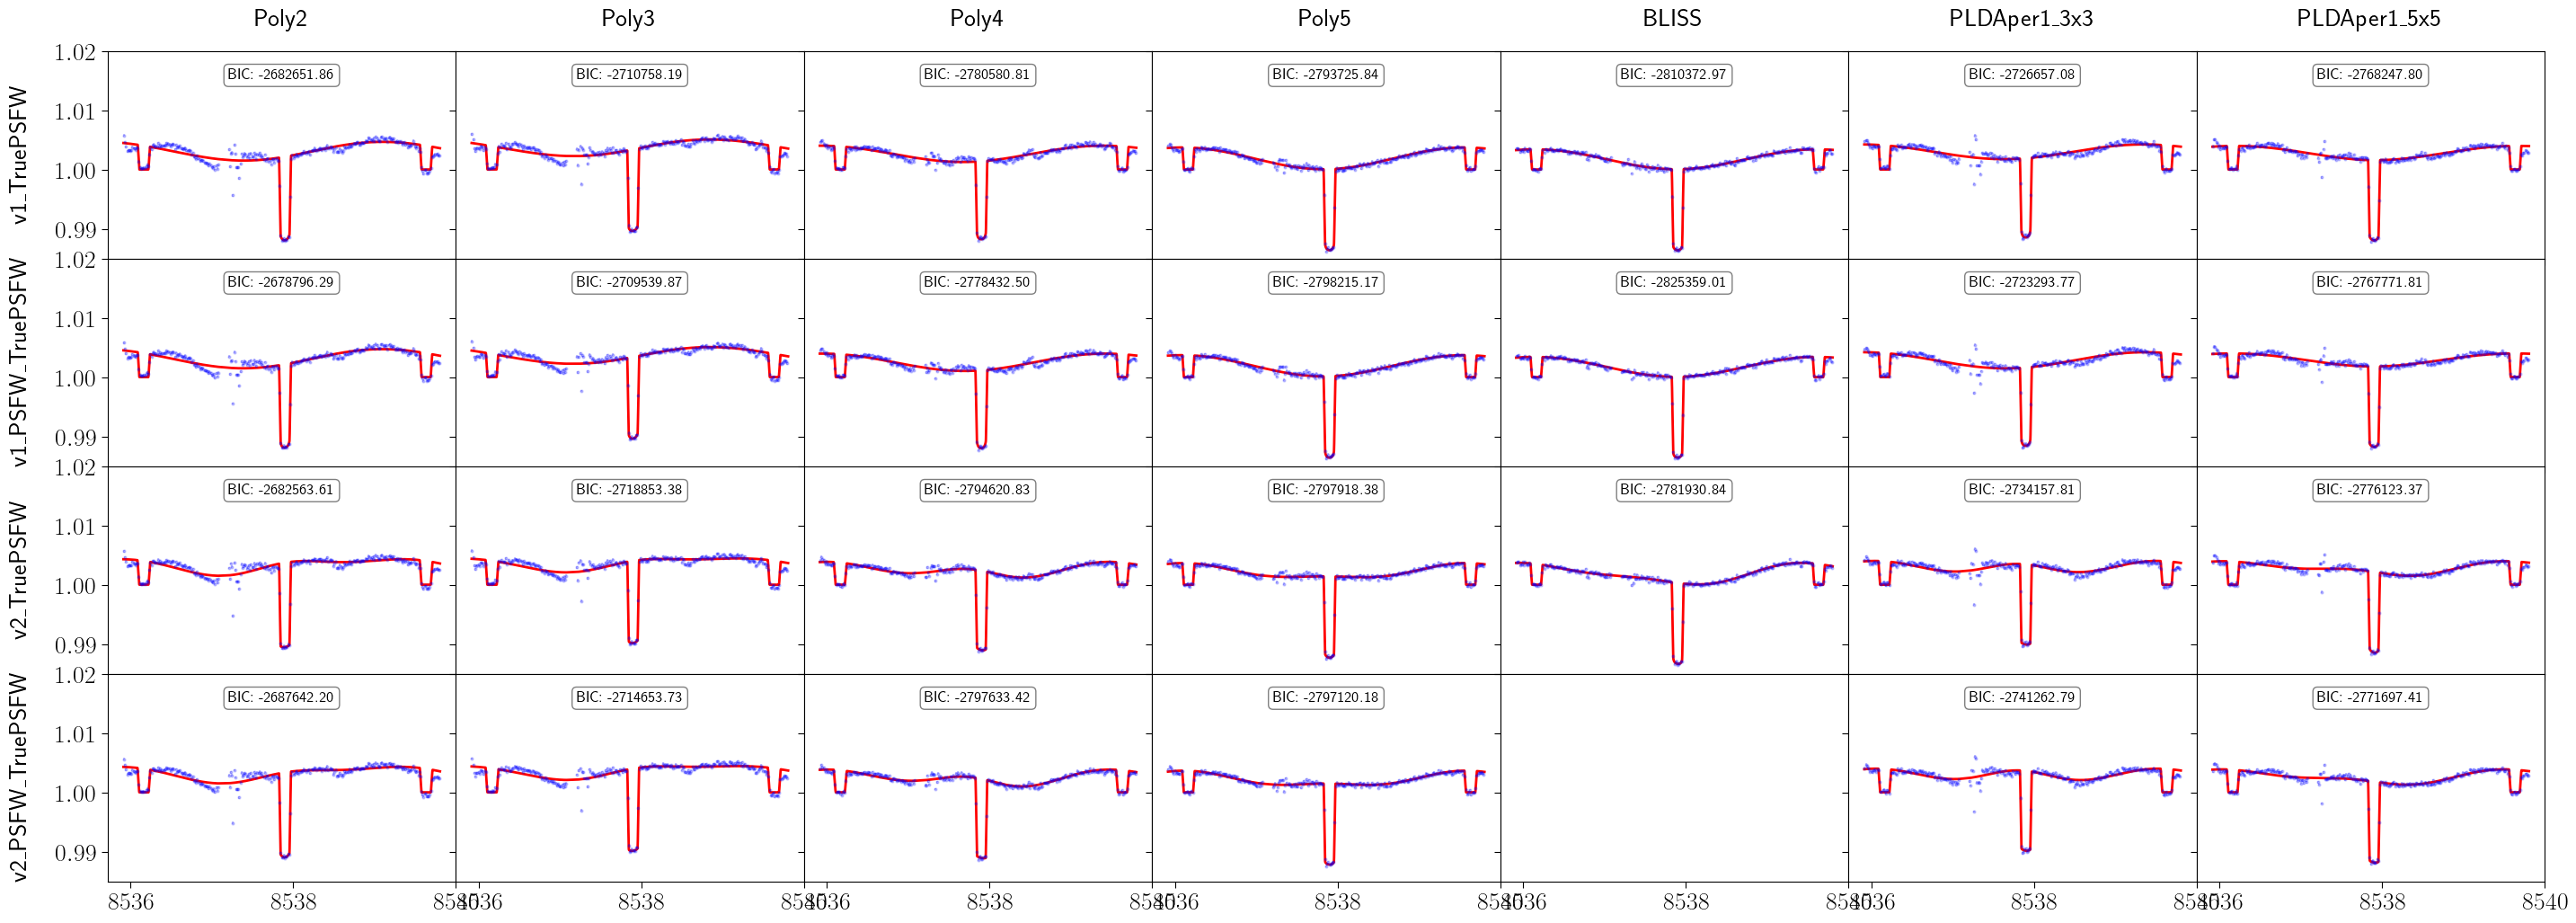

In [159]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import glob
import pickle
from SPCA import helpers

mintime = 8536.0+2450000.5 # 56417.2414096537
maxtime = 8539.8+2450000.5 # 56420.8356839537

minflux = 0.985
maxflux = 1.02

# Define the create_subplot_names function here (as provided earlier)

def create_subplot_names(rows, cols):
    # Create a dictionary to store subplot axes and their names
    subplot_names = {}

    # Create subplots with increased spacing
    fig, axes = plt.subplots(nrows=len(rows), ncols=len(cols), sharex=True, sharey=True, figsize=(35, len(rows) * 3))

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0, hspace=0)  # Adjust the values as needed
    plt.ylim(minflux, maxflux)

    # Iterate through rows and columns to name the subplots
    for i, row in enumerate(rows):
        for j, col in enumerate(cols):
            subplot_name = f"{col}_{row}"  # Switched order to col_row
            ax = axes[i, j]
            subplot_names[subplot_name] = ax

            # Set the title in the middle of each subplot
            # ax.set_title(subplot_name, fontsize=15, x=0.5, y=0.5, loc="center")  # Adjust the fontsize as needed

            # Set row names as labels for y axes for the first column
            if j == 0:
                ax.set_ylabel(row, fontsize=20, labelpad=20)  # Row name as y-axis label

    # Set column names at the top of the subplot (not as titles)
    for j, col in enumerate(cols):
        ax = axes[0, j]  # Access the top row of subplots
        ax.xaxis.set_label_position('top')  # Move the x-axis label to the top
        ax.set_xlabel(col, fontsize=20, labelpad=20)  # Column name as x-axis label

    return fig, subplot_names

def plot_model(time, flux, astro, detec, breaks, 
               axName=None, bic=None,
               savepath=None, plotName='Combined_plot.pdf', plotTrueAnomaly=False, nbin=None, fontsize=20):
    
    mcmc_signal = astro * detec
    
    if plotTrueAnomaly:
        x = time
    else:
        x = time - 5e4
    
    if nbin is not None:
        x_binned, _ = helpers.binValues(x, x, nbin)
        calibrated_binned, calibrated_binned_err = helpers.binValues(flux / detec, x, nbin, assumeWhiteNoise=True)
        residuals_binned, residuals_binned_err = helpers.binValues(flux / detec - astro, x, nbin, assumeWhiteNoise=True)
    
    # fig, axes = plt.subplots()
    axes = subplot_dict[axName]
    print('Mode {} plotted'.format(axName))

    # axes.plot(x, flux / detec, '.', color='k', markersize=4, alpha=0.15)
    axes.plot(x, astro, color='r', linewidth=2)
    if nbin is not None:
        axes.errorbar(x_binned, calibrated_binned, yerr=calibrated_binned_err, fmt='.',
                      color='blue', markersize=4, alpha=0.2)

    if bic is not None:
        axes.text(0.5, 0.85, f"BIC: {bic:.2f}", transform=axes.transAxes,
                  fontsize=12, ha='center', va='bottom', bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.5))
    
    return # x, astro, x_binned, calibrated_binned
    

# Example usage
rows = ['v1_TruePSFW', 'v1_PSFW_TruePSFW', 'v2_TruePSFW', 'v2_PSFW_TruePSFW']
cols = ['Poly2', 'Poly3', 'Poly4', 'Poly5', 'BLISS', 'PLDAper1_3x3', 'PLDAper1_5x5']
fig, subplot_dict = create_subplot_names(rows, cols)

# Set the mainpath, planets, channels, path, and other variables
mainpath = '/home/ldang05/projects/def-ncowan/ldang05/Spitzer_Data/'
planets = ['KELT-20b']
channels = ['ch2']
path = mainpath + planets[0] + '/analysis/' + channels[0] + '/addedBlank/noIgnore/'

mode_list = []
for mode_c in cols:
    for mode_r in rows:
        mode_cat = mode_c + '_' + mode_r
        mode_list.append(mode_cat)

found_modes = set()

# List all files and directories in the specified path
contents = os.listdir(path)
bic_values_dict = {}

# Iterate through the contents and print their names
for dir_4um in contents:
    dir_path = os.path.join(path, dir_4um)
    mode_folders = os.listdir(dir_path)

    for mode_folder in mode_folders:
        if mode_folder in mode_list:
            found_modes.add(mode_folder)
            mode_path = os.path.join(dir_path, mode_folder)
            bestfit_file = glob.glob(os.path.join(mode_path, 'Bestfit_*.pkl'))[0]
            

            evidence_file = glob.glob(os.path.join(mode_path, 'EVIDENCE_*.txt'))[0]
            with open(evidence_file, 'r') as file:
                evidence = file.read()
                evidence_lines = evidence.split('\n')
                last_line = evidence_lines[-1]
                words = last_line.split()
                bic = float(words[-1])
                bic_values_dict[mode_folder] = bic
            
            with open(bestfit_file, 'rb') as file:
                bestfit_data = pickle.load(file)

            # Extract data from loaded_data
            time = bestfit_data[1]
            flux = bestfit_data[2]
            astro = bestfit_data[3]
            detec = bestfit_data[4]
            breaks = bestfit_data[5]

            plot_model(time, flux, astro, detec, breaks, axName=mode_folder, nbin=300, bic=bic)

print('bic_values_dict is', bic_values_dict)
not_found_modes = set(mode_list) - found_modes
print('Modes not found in mode_folder:', ' '.join(not_found_modes))

[-2797918.3768216595, -2825359.012633031, -2798215.16652038, -2778432.5031481925, -2780580.8139418373, -2682651.8641859903, -2678796.289591258, -2718853.379858404, -2709539.8688871856, -2781930.843980743, -2710758.193623078, -2797120.181838846, -2810372.9749321076, -2797633.4185953233, -2682563.607336362, -2794620.8273757272, -2687642.199323758, -2714653.7309615756, -2793725.8374470156, -2726657.075352424, -2741262.792128318, -2723293.7722802465, -2734157.8058988485, -2768247.8037981805, -2771697.413637797, -2776123.3685877635, -2767771.8081753217]


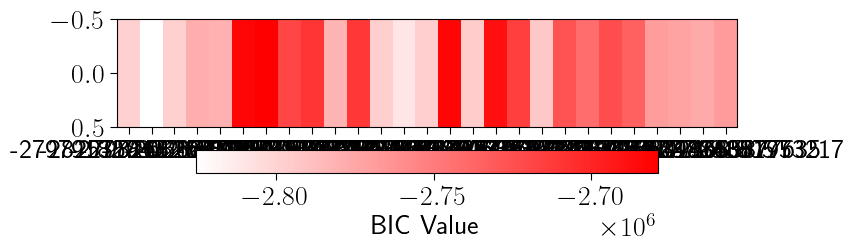

In [161]:
from matplotlib.colors import LinearSegmentedColormap

# def assign_colors_to_bic(bic_values):
#     # Create a colormap that goes from light to dark red
#     cmap = LinearSegmentedColormap.from_list('custom_red', [(1, 0, 0, 0), (1, 0, 0, 1)], N=256)
    
#     # Normalize BIC values to [0, 1] for colormap
#     norm = plt.Normalize(min(bic_values), max(bic_values))
    
#     # Map BIC values to colors
#     colors = cmap(norm(bic_values))
    
#     return colors

# colors = assign_colors_to_bic(list(bic_values_dict.values()))

# print(colors)
# import matplotlib.pyplot as plt
# from matplotlib.colors import LinearSegmentedColormap
# import numpy as np

# Sample BIC values and assign colors
# bic_values = [100, 200, 300, 400, 500]
bic_values = list(bic_values_dict.values())
print(bic_values)
cmap = LinearSegmentedColormap.from_list('custom_red', [(1, 0, 0, 0), (1, 0, 0, 1)], N=256)
norm = plt.Normalize(min(bic_values), max(bic_values))
colors = cmap(norm(bic_values))

# Create a color bar plot
fig, ax = plt.subplots(figsize=(8, 2))
cax = ax.imshow([bic_values], cmap=cmap, aspect='auto')
plt.colorbar(cax, orientation='horizontal', label='BIC Value')

# Set the x-axis labels
ax.set_xticks(np.arange(len(bic_values)))
ax.set_xticklabels(bic_values)

# Show the plot
plt.show()
